In [73]:
import pandas as pd
import numpy as np

In [74]:
%matplotlib inline

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
events_data = pd.read_csv('event_data_train.csv')

In [77]:
submissions_data = pd.read_csv('submissions_data_train.csv')

In [78]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [79]:
events_data.head(10) # unix time

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [80]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [81]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [82]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [83]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [84]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

In [85]:
events_data['day'] = events_data.date.dt.date

In [86]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


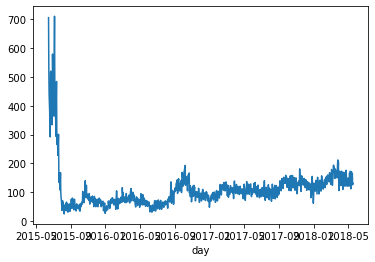

In [87]:
events_data.groupby('day') \
    .user_id.nunique().plot()

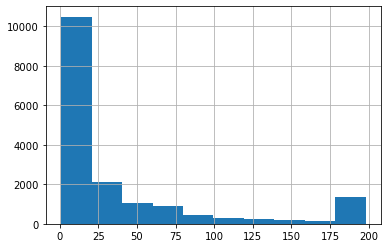

In [88]:
# INCORRECT SOLUTION!
events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index=False) \
    .agg({'step_id' : 'count'}) \
    .rename(columns={'step_id' : 'passed_steps'}).passed_steps.hist()

#### Однако, пользователи, у которых нет ни одного passed стэпа вообще не попадут в результат.

In [89]:
# проверяем так, чтобы никогда не терять уников в процессе анализа

In [90]:
events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count',
                        fill_value=0).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [186]:
users_events_data = events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count',
                        fill_value=0).reset_index()

In [187]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [184]:
users_scores = submissions_data.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count',
                        fill_value=0).reset_index()

In [185]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [94]:
events_data[['step_id', 'user_id']].head().drop_duplicates() #useful

,step_id,user_id
0,32815,17632
3,32811,17632


In [103]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [104]:
gap_data =  pd.Series(np.concatenate(gap_data, axis=0))
# axis = 0 – rows, whereas axis = 1 – columns

In [97]:
gap_data = gap_data / (24 * 60 * 60)

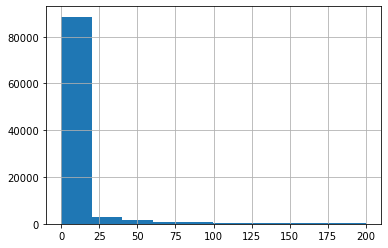

In [98]:
gap_data[gap_data < 200].hist()

In [99]:
gap_data.quantile(0.95) 
# only 5% of the users return to the course
# after gap in 59 days

59.760440972222156

In [100]:
gap_data.quantile(0.90) 

18.325995370370403

In [101]:
# Какого времени достаточно, чтобы считать пользователя дропнушивмся?

In [171]:
gap_data.quantile(0.90)  / (24 * 60 * 60)

18.325995370370403

In [108]:
30 * 24 * 60 * 60 # timestamp porogowy

2592000

In [172]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [173]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp' : 'max'}).rename(columns={'timestamp' : 'last_timestamp'})

In [174]:
now = 1526772811
drop_out_threshold = 2592000

In [175]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold

In [176]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [177]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [178]:
users_data = users_data.fillna(0)

In [188]:
users_data = users_data.merge(users_events_data, how='outer')

In [189]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [190]:
users_data = users_data.merge(users_days, how='outer')

In [191]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,day,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,1,0,0,1
1,2,1519226966,True,2.0,0.0,2,9,9,2,10
2,3,1444581588,True,29.0,23.0,7,91,87,30,192
3,5,1499859939,True,2.0,2.0,2,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,1,0,1


In [193]:
users_data['passed_course'] = users_data.passed > 170

In [194]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,day,discovered,passed,started_attempt,viewed,passed_course
0,1,1472827464,True,0.0,0.0,1,1,0,0,1,False
1,2,1519226966,True,2.0,0.0,2,9,9,2,10,False
2,3,1444581588,True,29.0,23.0,7,91,87,30,192,False
3,5,1499859939,True,2.0,2.0,2,11,11,4,12,False
4,7,1521634660,True,0.0,0.0,1,1,1,0,1,False


In [195]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,day,discovered,passed,started_attempt,viewed
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [196]:
users_data.user_id.nunique()

19234

In [197]:
events_data.user_id.nunique()

19234

#### practice easter egg

In [61]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [62]:
events_data.action.value_counts()

viewed             1830830
discovered          689495
passed              650331
started_attempt     310047
Name: action, dtype: int64

In [63]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [64]:
submissions_data

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06


In [71]:
submissions_data[submissions_data.submission_status == 'correct'] \
.groupby('user_id', as_index=False) \
.agg({'submission_status' : 'count'}) \
.sort_values(by=['submission_status'], ascending=False).head(20)


,user_id,submission_status
433,1046,421
2062,5552,186
6323,17135,168
2302,6183,142
3151,8461,135
508,1218,130
8761,24022,121
5424,14699,121
8,30,119
8288,22713,117
